In [192]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Imports and Paths

In [2]:
from pathlib import Path
import gc
from functools import partial
import time
import datetime
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.linalg
import copy
import sklearn
import rastermap
import pandas as pd
from tqdm.notebook import tqdm

import tensorly as tl
import tensorly.decomposition
import torch

In [3]:
# import sys
# sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from bnpm import torch_helpers, file_helpers, timeSeries, ca2p_preprocessing, welford_moving_2D, linear_regression, similarity, spectral, featurization, decomposition, h5_handling, math_functions

%load_ext autoreload
%autoreload 2
import roicat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%load_ext autoreload
%autoreload 2
import bmi_idap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%matplotlib inline

In [6]:
params = {}
results = {}

In [7]:
results['general'] = {}

results['general']['datetime'] = str(datetime.datetime.now())
results['general']['cwd'] = os.getcwd()

In [8]:
params['paths'] = {}

# params['paths']['dir_analysisFiles'] = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_2_6').resolve())
# params['paths']['dir_analysisFiles'] = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_1511L').resolve())
params['paths']['dir_analysisFiles'] = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/analysis_data/').resolve())

## Directory with F.npy, stat.npy etc.
# params['paths']['dir_s2p']   = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_2_6/statFiles/20210409').resolve())
# params['paths']['dir_s2p']     = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_1511L/statFiles/20230111').resolve())
params['paths']['dir_s2p']   = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/analysis_data/suite2p/plane0').resolve())



## Path of iscell. Can be from neural net output (iscell_NN)
params['paths']['path_iscell'] = str(Path(params['paths']['dir_analysisFiles']) / 'iscell_NN_tqm.npy')

## Path of tqm (trace quality metrics). Used to get dFoF parameters
params['paths']['path_tqm'] = str(Path(params['paths']['dir_analysisFiles']) / 'trace_quality.pkl')


params['paths']['dir_save']       =  copy.copy(params['paths']['dir_analysisFiles'])
params['paths']['path_save_weights'] = str(Path(params['paths']['dir_save']) / 'weights_day0')
params['paths']['path_save_results'] = str(Path(params['paths']['dir_save']) / 'decoder_definition')

In [9]:
params['general'] = {}

params['general']['use_gpu'] = True

In [10]:
device = torch_helpers.set_device(use_GPU=params['general']['use_gpu'])

results['device'] = device

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


In [11]:
iscell = np.load(params['paths']['path_iscell'])
tqm = file_helpers.pickle_load(params['paths']['path_tqm'])

In [12]:
## == IMPORT DATA ==
F, Fneu, iscell_s2p, ops, spks_s2p, stat = ca2p_preprocessing.import_s2p(params['paths']['dir_s2p'])
n_frames, n_rois = F.shape[1], F.shape[0]
Fs = ops['fs']

In [13]:
frame_height, frame_width = ops['meanImg'].shape[0], ops['meanImg'].shape[1]

# sf = import_and_convert_to_CellReg_spatialFootprints([dir_s2p / 'stat.npy'], frame_height=frame_height, frame_width=frame_width, dtype=np.float32)[0]

data_rois = roicat.data_importing.Data_suite2p([str(Path(params['paths']['dir_s2p']) / 'stat.npy')], FOV_height_width=(frame_height, frame_width))
sf = data_rois.spatialFootprints[0]

Completed: Set FOV_height and FOV_width successfully.
Importing spatial footprints from stat files.


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]


Imported 1 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 1 sessions successfully.
Completed: Created sessionID_concat.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


In [14]:
results['data'] = {}

results['data']['data'] = n_frames
results['data']['n_rois'] = n_rois
results['data']['Fs'] = Fs
results['data']['frame_height'] = frame_height
results['data']['frame_width'] = frame_width
results['data']['spatialFootprints'] = sf
results['data']['iscell'] = iscell

# Prepare dFoF

In [15]:
idx_time_bad = np.arange(0,0)

idx_time_good = np.arange(n_frames)[~np.isin(np.arange(n_frames), idx_time_bad)]

In [16]:
results['idx_time_bad'] = idx_time_bad

In [17]:
F_toUse = F[iscell][:, idx_time_good]
Fneu_toUse = Fneu[iscell][:, idx_time_good]

In [18]:
params['dFoF'] = {}

params['dFoF']['channelOffset_correction'] = tqm['dFoF_params']['channelOffset_correction']
params['dFoF']['percentile_baseline'] = tqm['dFoF_params']['percentile_baseline']
params['dFoF']['neuropil_fraction'] = tqm['dFoF_params']['neuropil_fraction']
params['dFoF']['win_rolling_percentile'] = 10*60*results['data']['Fs']  ## In frames

In [19]:
# dFoF with reduced percentile for baseline

dFoF, dF, F_neuSub, F_baseline = ca2p_preprocessing.make_dFoF(
    F=F_toUse,
    Fneu=Fneu_toUse,
    neuropil_fraction=params['dFoF']['neuropil_fraction'],
    percentile_baseline=params['dFoF']['percentile_baseline'],
    rolling_percentile_window=params['dFoF']['win_rolling_percentile'],
    channelOffset_correction=params['dFoF']['channelOffset_correction'],
    multicore_pref=True,
    verbose=True
)
# # Threshold for nonnegativity
# dFoF_z = dFoF / np.std(dFoF,axis=1,keepdims=True)

100%|███████████████████████████████████████████| 36/36 [00:09<00:00,  3.88it/s]


Calculated dFoF. Total elapsed time: 11.75 seconds


In [20]:
np.sum(dFoF > 30)

0

In [21]:
# dFoF = np.nan_to_num(dFoF)

### Look at rastermap

In [22]:
import rastermap

In [23]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [24]:
# X = scipy.stats.zscore(dFoF, axis=0).T
# X = scipy.stats.zscore(dFoF, axis=1)
# X = dFoF / np.std(dFoF, axis=1, keepdims=True)
X = dFoF.copy()
rmap.fit(X)

nmin 200
0.1480720043182373
5.95341157913208
6.303774356842041
6.306019306182861
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.26s     0        0.1687      2
0.30s    10        0.2997      4
0.40s    20        0.3212      8
0.44s    30        0.3578      18
0.52s    40        0.3888      28
0.60s    50        0.4134      38
0.68s    60        0.4144      38
0.72s   final      0.4147
0.72s upsampled    0.4147


<IPython.core.display.Javascript object>


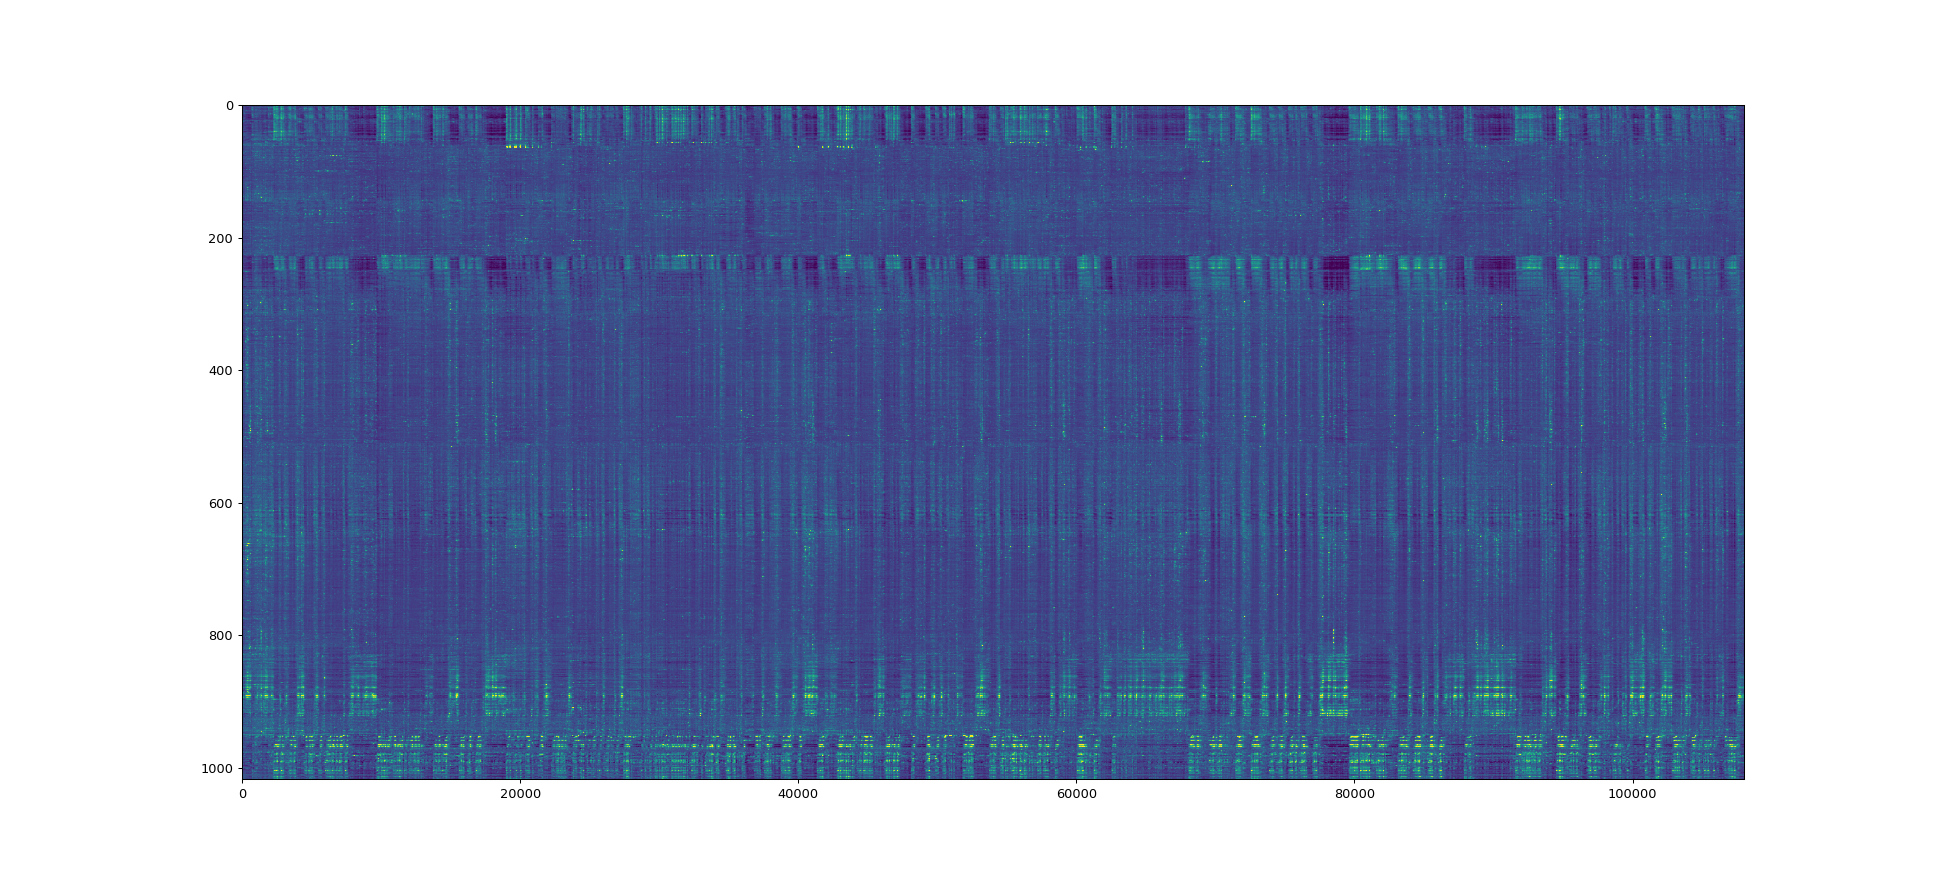

In [36]:
%matplotlib notebook

plt.figure()
plt.imshow(X[rmap.isort], aspect='auto', vmin=-0.2, vmax=1)

# %matplotlib inline

# Pre-orthogonalization

### Define traces to orthogonalize out:
- Mean neuron trace (average vector)
    - multiple frequency components
- Mean neuropil trace
    - multiple frequency components

In [38]:
params['preorthogonalization'] = {}

params['preorthogonalization']['bandpass_freqs_boundaries'] = [0, 1/(60*5), 1/20, 1/2, 5, np.inf]
params['preorthogonalization']['mspline_grid_order'] = 3
params['preorthogonalization']['mspline_grid_numSplines'] = 4
params['preorthogonalization']['num_taps'] = 10001
params['preorthogonalization']['window'] = ('kaiser', 3.0)

In [39]:
dFoF_mean = np.nanmean(dFoF, axis=0)
Fneu_mean = np.nanmean(Fneu_toUse, axis=0)

<IPython.core.display.Javascript object>


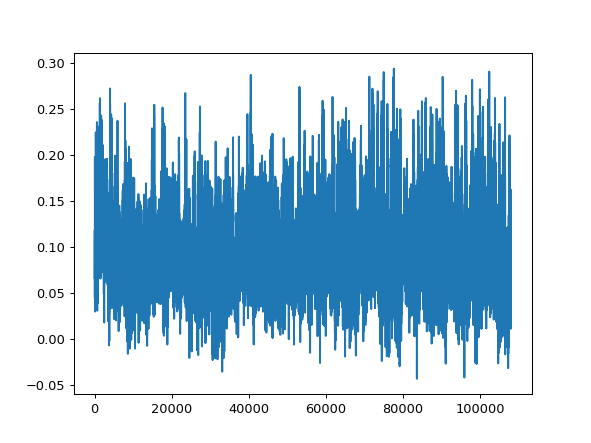

<IPython.core.display.Javascript object>


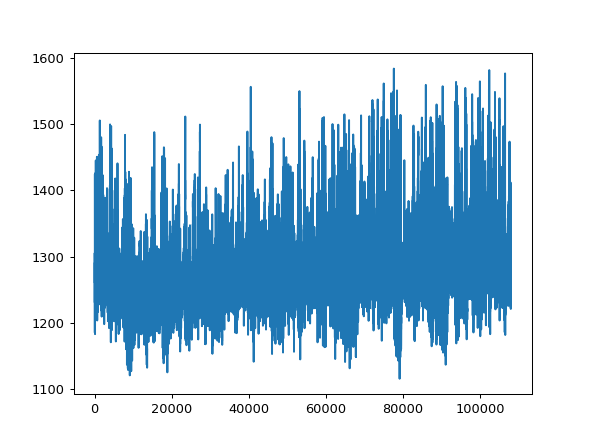

In [40]:
plt.figure()
plt.plot(dFoF_mean)

plt.figure()
plt.plot(Fneu_mean)

### spectral expansion

Make a set of band pass filter, then filter traces with each filter

In [41]:
bpfb = params['preorthogonalization']['bandpass_freqs_boundaries'] 

bandpass_ab = [spectral.design_fir_bandpass(bp_1, bp_2, num_taps=params['preorthogonalization']['num_taps'], fs=Fs, window=params['preorthogonalization']['window'], plot_pref=False) for ii, (bp_1, bp_2) in enumerate(zip(bpfb[:-1], bpfb[1:]))]

In [42]:
traces = [spectral.plot_digital_filter_response(b=h, fs=Fs, worN=100000, plot_pref=False) for h in tqdm(bandpass_ab)]

  0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


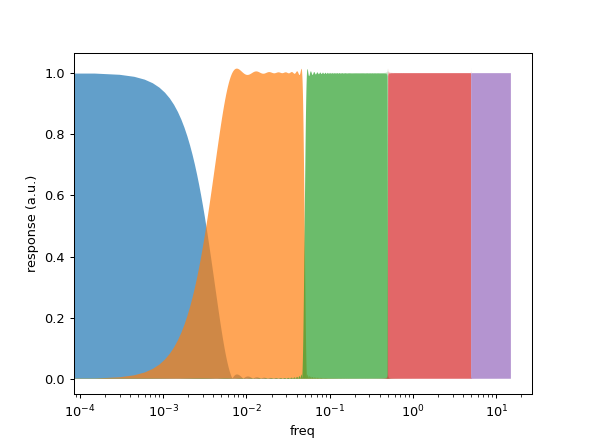

In [43]:
plt.figure()
[(plt.fill_between(t[0], t[1], alpha=0.7), plt.xscale('log'), plt.xlabel('freq'), plt.ylabel('response (a.u.)')) for t in traces];

In [44]:
sigs = np.stack(
    [scipy.signal.filtfilt(h, 1.0, dFoF_mean - dFoF_mean.mean()) for h in tqdm(bandpass_ab)] + \
    [scipy.signal.filtfilt(h, 1.0, Fneu_mean - Fneu_mean.mean()) for h in tqdm(bandpass_ab[:])] + \
    [np.linspace(-1, 1, n_frames, endpoint=True)] + \
    [np.ones(n_frames)] + \
    list(featurization.mspline_grid(order=params['preorthogonalization']['mspline_grid_order'], num_basis_funcs=params['preorthogonalization']['mspline_grid_numSplines'], nt=n_frames)),
    
    axis=0
).astype(np.float32)

sigs = sigs - sigs.mean(1, keepdims=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


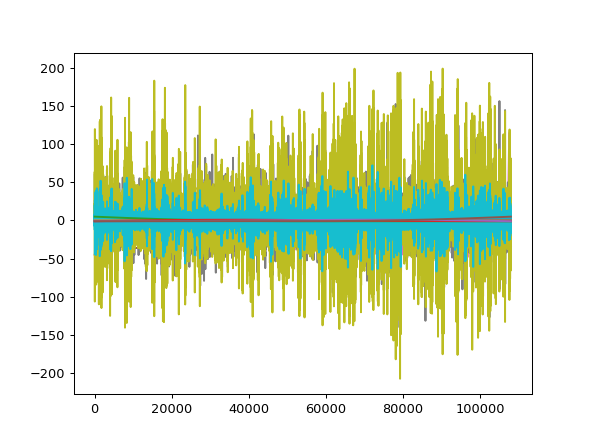

<IPython.core.display.Javascript object>


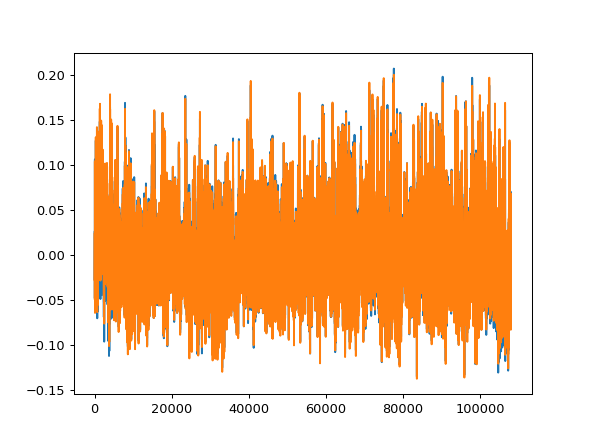

In [46]:
%matplotlib notebook

plt.figure()
plt.plot(sigs.T);

plt.figure()
plt.plot(sigs[:5].sum(0))
plt.plot(dFoF_mean - dFoF_mean.mean())

# %matplotlib inline

In [47]:
v1_orth, EVR, EVR_total, pca_dict = similarity.orthogonalize((dFoF - dFoF_mean).T, sigs.T, method='OLS', device=device)

dFoF_orth = v1_orth.T - np.percentile(v1_orth.T, params['dFoF']['percentile_baseline'], axis=1)[:,None]

print(f"Total variance ratio in dFoF orthogonalized out: {EVR_total :.4f}")

Total variance ratio in dFoF orthogonalized out: 0.0593


In [48]:
results['preorthogonalization'] = {}

results['preorthogonalization']['signals'] = sigs
results['preorthogonalization']['EVR_total'] = EVR_total
results['preorthogonalization']['dFoF_mean'] = dFoF_mean
results['preorthogonalization']['Fneu_mean'] = Fneu_mean

In [49]:
import rastermap

In [50]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [51]:
X = dFoF_orth.copy()
# X = dFoF_orth / np.std(dFoF_orth, axis=1, keepdims=True)
# X = timeSeries.simple_smooth(X, sig=4, axis=1)
rmap.fit(X)

nmin 200
0.3256497383117676
9.75069260597229
10.238119840621948
10.241855144500732
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.00s     0        0.1472      2
0.04s    10        0.2406      4
0.08s    20        0.2693      8
0.12s    30        0.3034      18
0.17s    40        0.3327      28
0.25s    50        0.3598      38
0.33s    60        0.3615      38
0.38s   final      0.3621
0.38s upsampled    0.3621


<IPython.core.display.Javascript object>


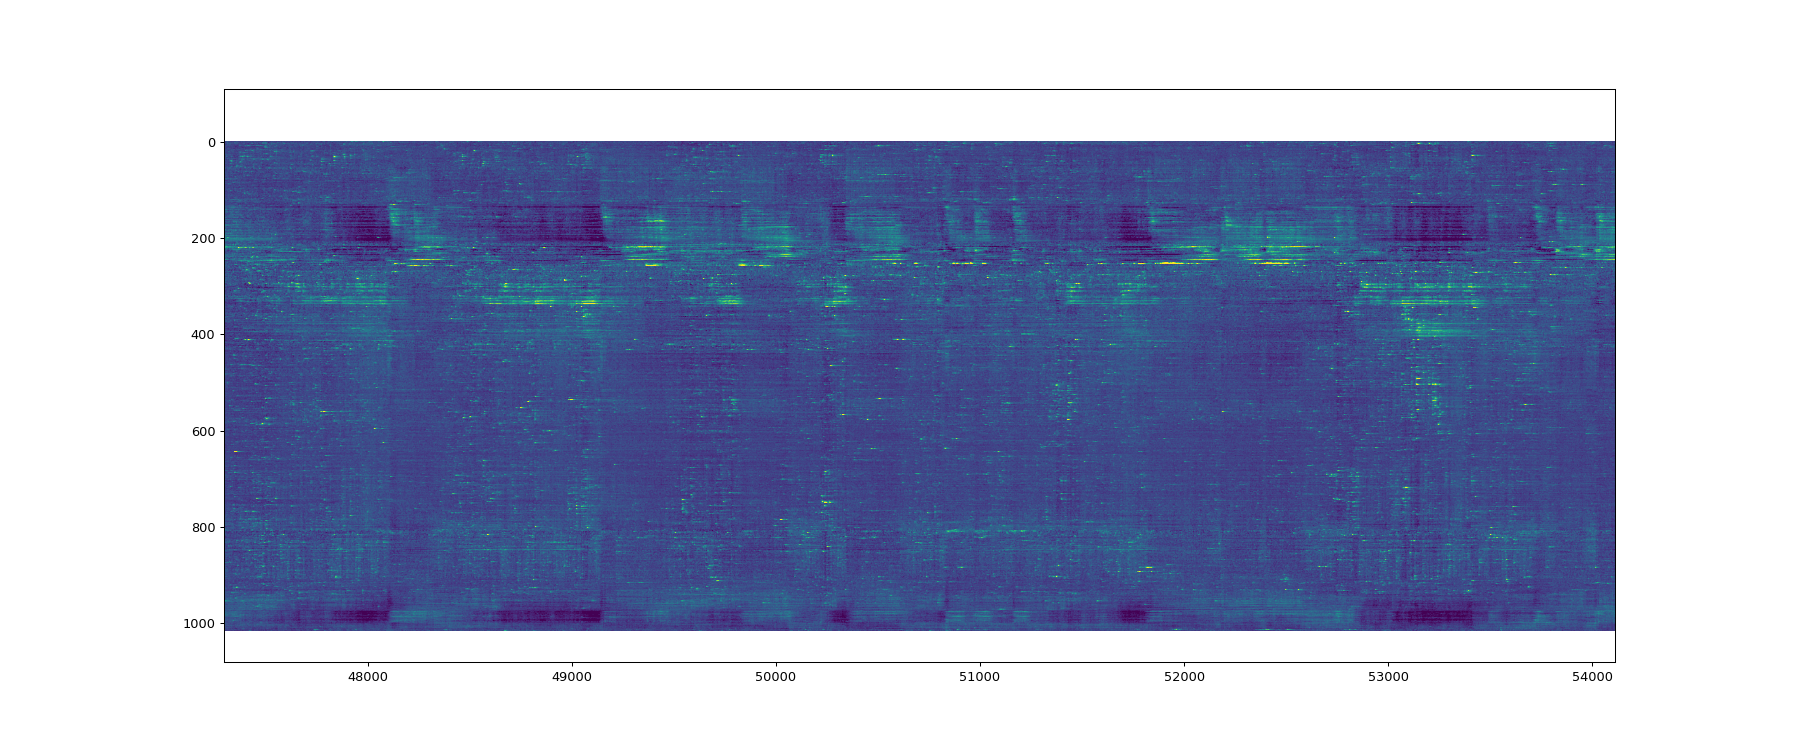

In [54]:
%matplotlib notebook

plt.figure()
plt.imshow(X[rmap.isort], aspect='auto', vmin=-0.2, vmax=1)

# %matplotlib inline

In [60]:
params['rank'] = 6

params['spca'] = {}
# params['spca']['alphas'] = [10, 20, 40, 60, 100]
# params['spca']['alphas'] = [20, 40, 60,]
# params['spca']['alphas'] = [7, 9, 12]
params['spca']['alphas'] = [13, 15, 17]

params['spca']['tol_sweep'] = 1e-4
params['spca']['tol_final'] = 1e-6

params['spca']['n_neurons_nonZero_goal'] = dFoF.shape[0] * 0.05
print(f"n_neurons_nonZero_goal: {params['spca']['n_neurons_nonZero_goal']}")

neural_data_toUse = (dFoF_orth - dFoF_orth.mean(1, keepdims=True)).astype(np.float32)

n_neurons_nonZero_goal: 50.85


In [61]:
U, S, V = torch.svd(torch.as_tensor(neural_data_toUse.T, device=device, dtype=torch.float32), some=True)
U, S, V = U.cpu().numpy(), S.cpu().numpy(), V.cpu().numpy()
U, V = sklearn.utils.extmath.svd_flip(U, V)

spca_partials = partial(sklearn.decomposition.SparsePCA, n_components=6, ridge_alpha=0.01, max_iter=1000, method='lars', n_jobs=None, U_init=U, V_init=V, verbose=True, random_state=None)

In [62]:
spcas = {alpha: spca_partials(alpha=alpha, tol=params['spca']['tol_sweep'],) for alpha in params['spca']['alphas']}

[spca.fit(neural_data_toUse.T) for spca in tqdm(spcas.values())];

  0%|          | 0/3 [00:00<?, ?it/s]

[dict_learning] .................
[dict_learning] ............
[dict_learning] ..........


In [63]:
n_neurons_nonZero = {alpha: (s.components_ != 0).sum(1).mean() for alpha,s in spcas.items()}

idx_alpha_toUse = np.abs((np.array(list(n_neurons_nonZero.values())) - params['spca']['n_neurons_nonZero_goal'])).argmin()

alpha_toUse = list(n_neurons_nonZero.keys())[idx_alpha_toUse]

In [64]:
print('Number of nonzero components for neuron loadings')
print(f"Goal number of nonzero neurons: {params['spca']['n_neurons_nonZero_goal'] :.1f}")
[print(f"alpha: {key}: {val :.1f}") for key,val in n_neurons_nonZero.items()];

Number of nonzero components for neuron loadings
Goal number of nonzero neurons: 50.9
alpha: 13: 49.0
alpha: 15: 36.0
alpha: 17: 30.3


<IPython.core.display.Javascript object>


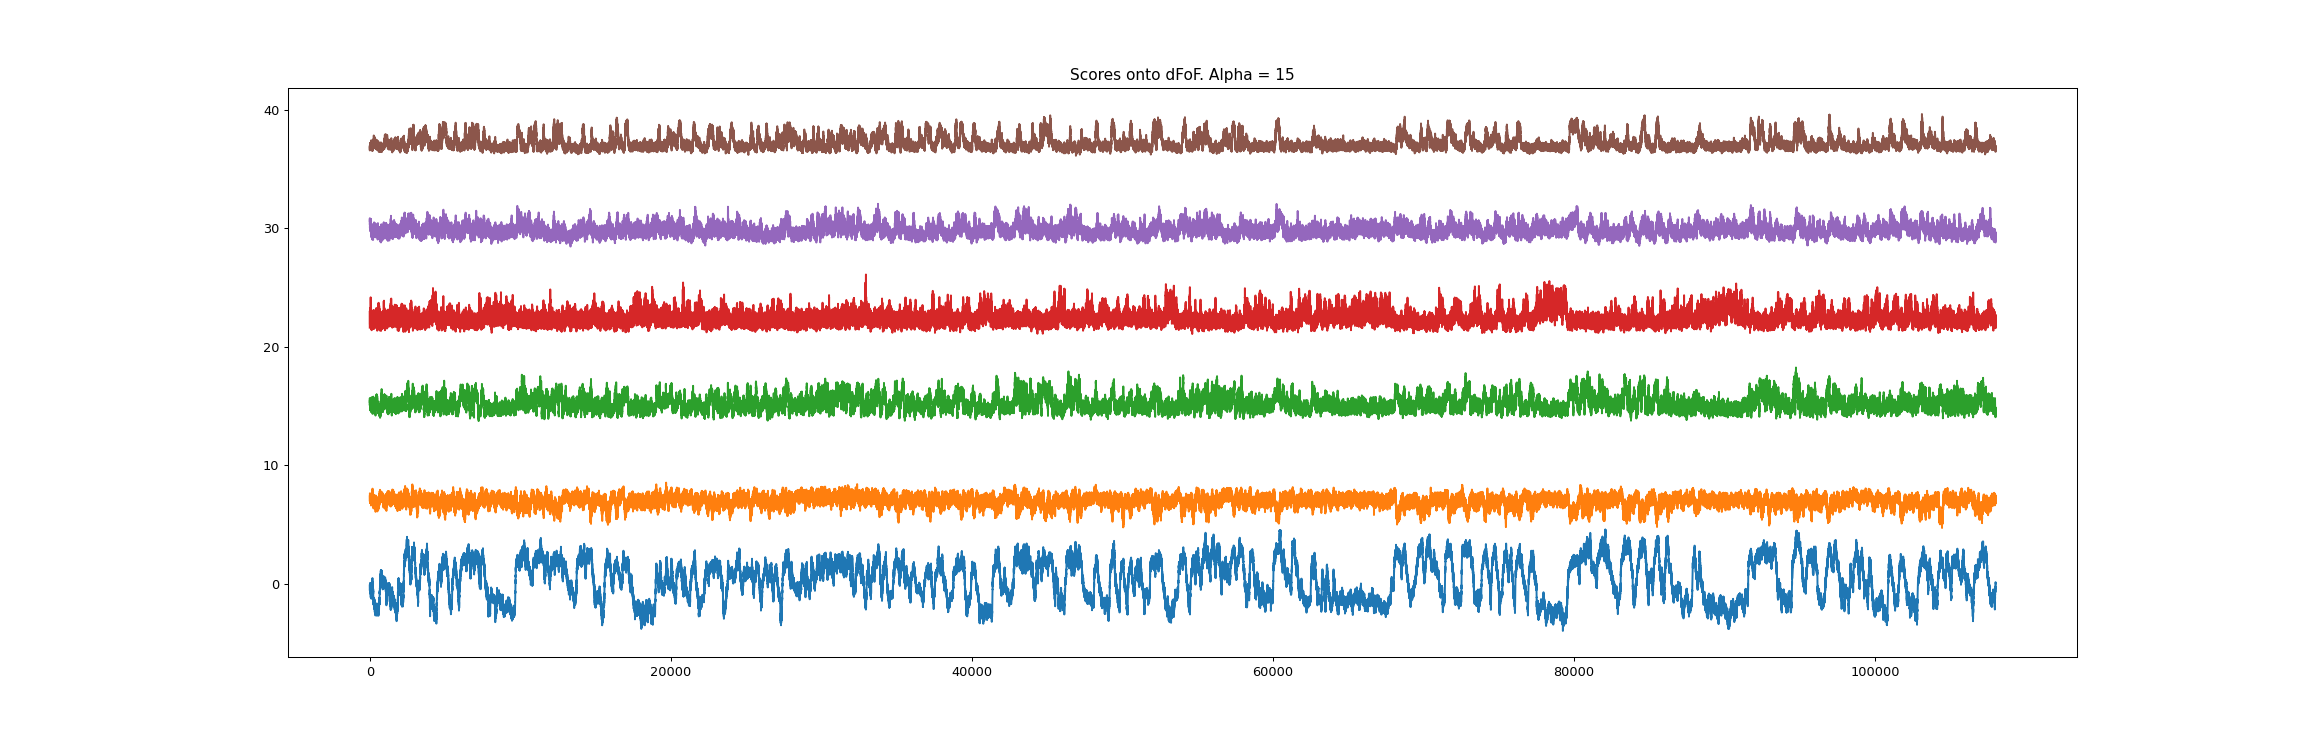

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Correlations of scores onto dFoF. Alpha = 15')

In [65]:
idx_alpha_toShow = 1

plt.figure(figsize=(25,8))
plt.plot(spcas[params['spca']['alphas'][idx_alpha_toShow]].transform(dFoF.T) + np.arange(params['rank'])*10*spcas[params['spca']['alphas'][idx_alpha_toShow]].transform(dFoF.T).std(1).mean());
plt.title(f"Scores onto dFoF. Alpha = {params['spca']['alphas'][idx_alpha_toShow]}")

plt.figure()
plt.imshow(np.corrcoef(spcas[params['spca']['alphas'][idx_alpha_toShow]].transform(dFoF.T).T), cmap='bwr', vmin=-1, vmax=1);
plt.title(f"Correlations of scores onto dFoF. Alpha = {params['spca']['alphas'][idx_alpha_toShow]}")

In [66]:
print(f"Running final SPCA at a lower tolerance with alpha={alpha_toUse}")
tic = time.time()

spca = spca_partials(alpha=alpha_toUse, tol=params['spca']['tol_final'])
scores = spca.fit_transform(neural_data_toUse.T)

print(f"Duration: {time.time() - tic:.2f}s")

Running final SPCA at a lower tolerance with alpha=13
[dict_learning] ..........................
Duration: 40.03s


In [67]:
results['spca'] = {}

results['spca']['alpha_toUse'] = alpha_toUse
results['spca']['objs_alphaSweep'] = {alpha: spca.__dict__ for alpha,spca in spcas.items()}
results['spca']['spca_obj'] = copy.deepcopy(spca.__dict__)
results['spca']['num_nonzero_neurons'] = (spca.components_ != 0).sum(1)

In [68]:
print(f'Number of nonzero components for neuron loadings:')
print(f"Mean: {results['spca']['num_nonzero_neurons'].mean() :.1f}")
print(f"Components: {results['spca']['num_nonzero_neurons']}")

Number of nonzero components for neuron loadings:
Mean: 47.7
Components: [144 105   7  14   8   8]


<IPython.core.display.Javascript object>


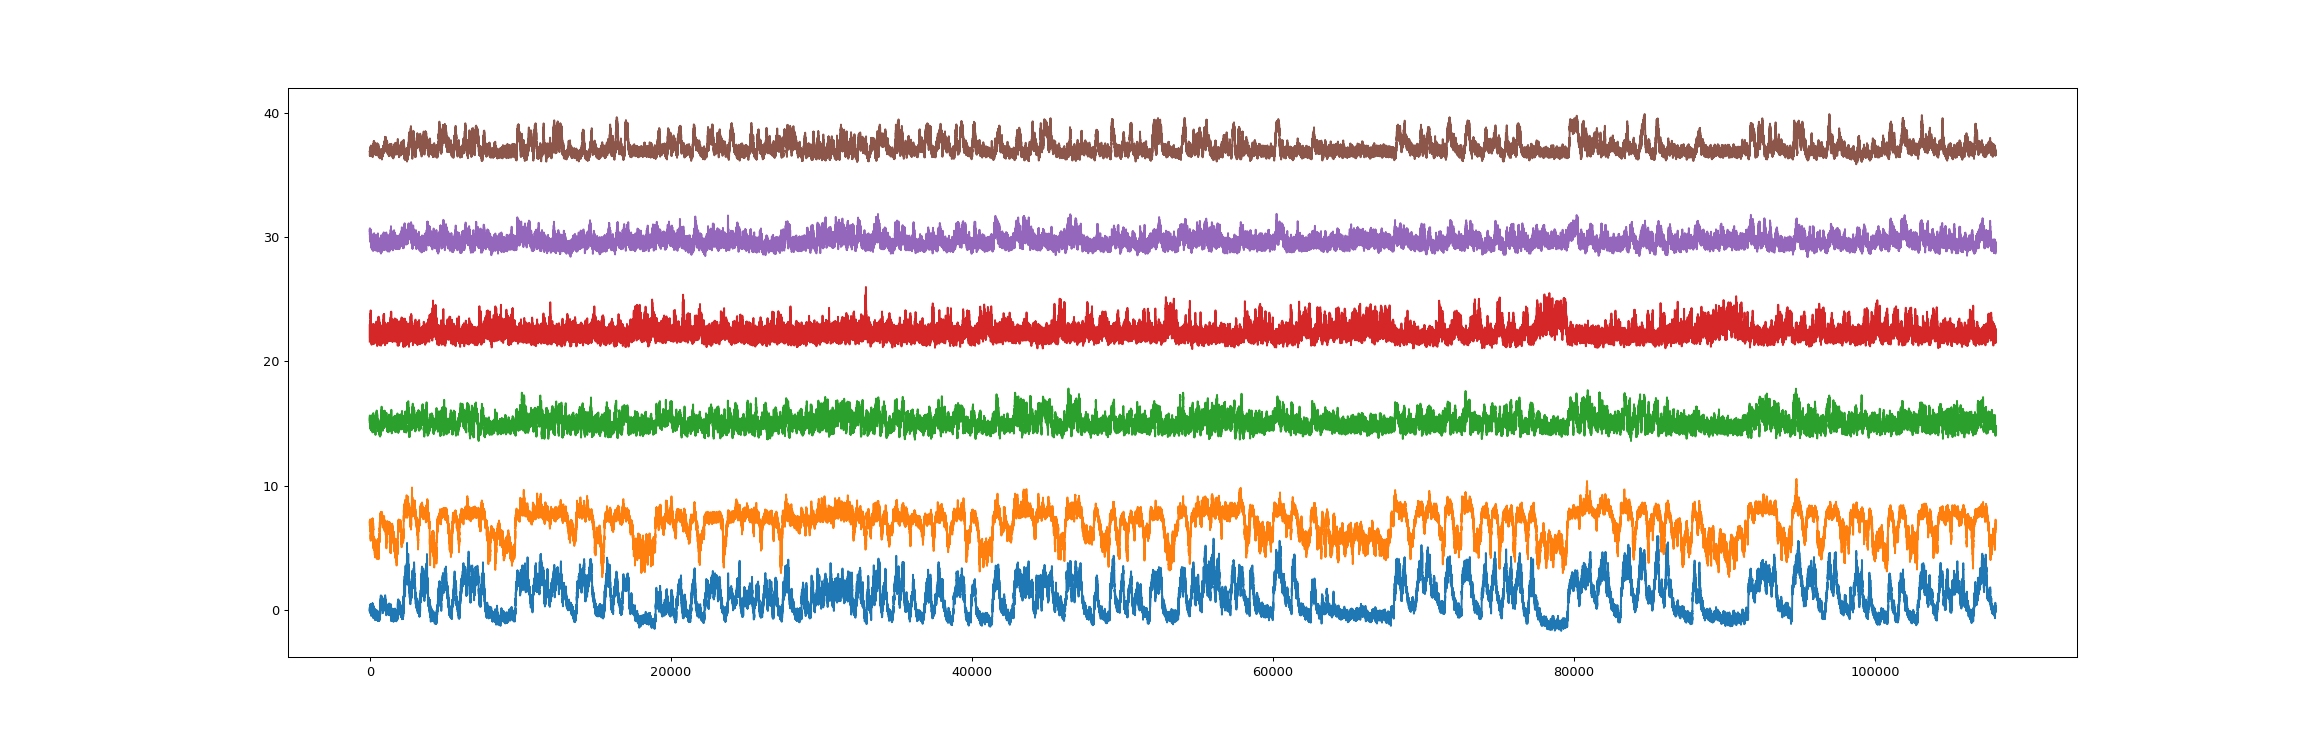

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'correlation of neuron loadings')

In [69]:
plt.figure(figsize=(25,8))
plt.plot(spca.transform(dFoF.T) + np.arange(params['rank'])*10*spca.transform(dFoF.T).std(1).mean());

fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].plot(results['spca']['spca_obj']['components_'].T);
axs[0].set_title('neuron loadings')
axs[1].imshow(np.corrcoef(scores.T), cmap='bwr', vmin=-1, vmax=1)
axs[1].set_title('correlation of temporal scores')
axs[2].imshow(np.corrcoef(results['spca']['spca_obj']['components_']), cmap='bwr', vmin=-1, vmax=1)
axs[2].set_title('correlation of neuron loadings')

In [71]:
weights = results['spca']['spca_obj']['components_'].copy()
sf_weights = (sf[iscell].T * weights.T).T.reshape(params['rank'], data_rois.FOV_height, data_rois.FOV_width)

%matplotlib notebook

fig, ax = plt.subplots(figsize=(16,8))
roicat.visualization.display_toggle_image_stack(
    sf_weights, 
    clim=[-sf_weights.max()/4, sf_weights.max()/4],
    fig=fig,
    ax=ax,
    cmap='bwr',
)

# %matplotlib inline

<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

In [72]:
factors_original = results['spca']['spca_obj']['components_'].copy()  ## shape (n_components, n_neurons)

In [73]:
scores_original = (neural_data_toUse.T @ factors_original.T).T  ## shape (n_components, n_timepoints)

In [74]:
factors_regressed, scores_regressed, bias = linear_regression.Ridge(neural_data_toUse.T, scores_original.T, lam=1*10**6, add_bias_terms=True)
factors_regressed = factors_regressed.T
scores_regressed = scores_regressed.T

In [75]:
factors_orth = bmi_idap.helpers.orthogonalize_matrix(factors_regressed)  ## shape (n_components, n_neurons)

In [76]:
scores_orth = (neural_data_toUse.T @ factors_orth.T).T  ## shape (n_components, n_timepoints)

In [77]:
factors_orth_ms = factors_orth - factors_orth.mean(1, keepdims=True)  ## shape (n_components, n_neurons)

In [78]:
factors_orth_ms_norm = factors_orth_ms / factors_orth_ms.std(1, keepdims=True)  ## shape (n_components, n_neurons)
scores_orth_ms_norm_raw = (dFoF.T @ factors_orth_ms_norm.T).T  ## shape (n_components, n_timepoints)

In [163]:
factors_orth_ms_norm_flipped = factors_orth_ms_norm * np.sign(scipy.stats.skew(scores_orth_ms_norm_raw, axis=1))[:,None]
scores_orth_ms_norm_flipped_raw = (dFoF.T @ factors_orth_ms_norm_flipped.T).T  ## shape (n_components, n_timepoints)

In [164]:
_, order = bmi_idap.helpers.order_factors_by_EVR(scores_orth_ms_norm_flipped_raw, dFoF, device=device)  

In [165]:
factors_orth_ms_norm_flipped_ordered = factors_orth_ms_norm_flipped[order]
scores_orth_ms_norm_flipped_ordered_raw = (neural_data_toUse.T @ factors_orth_ms_norm_flipped_ordered.T).T  ## shape (n_components, n_timepoints)

In [166]:
factors_final = np.concatenate([factors_orth_ms_norm_flipped_ordered, (np.ones(factors_orth_ms_norm_flipped_ordered.shape[1]))[None,:]], axis=0)
scores_final = (dFoF.T @ factors_final.T).T  ## shape (n_components, n_timepoints)

In [167]:
results['factors'] = {}

results['factors']['factors_original'] = factors_original
results['factors']['factors_regressed'] = factors_regressed
results['factors']['factors_orth'] = factors_orth
results['factors']['factors_orth_ms'] = factors_orth_ms
results['factors']['factors_orth_ms_norm'] = factors_orth_ms_norm
results['factors']['factors_orth_ms_norm_flipped'] = factors_orth_ms_norm_flipped
results['factors']['factors_orth_ms_norm_ordered'] = factors_orth_ms_norm_flipped_ordered
results['factors']['factors_final'] = factors_final

results['factors']['scores_original'] = scores_original
results['factors']['scores_regressed'] = scores_regressed
results['factors']['scores_orth'] = scores_orth
results['factors']['scores_orth_ms_norm_raw'] = scores_orth_ms_norm_raw
results['factors']['scores_orth_ms_norm_flipped_raw'] = scores_orth_ms_norm_flipped_raw
results['factors']['scores_orth_ms_norm_raw_ordered'] = factors_orth_ms_norm_flipped_ordered
results['factors']['scores_final'] = scores_final


In [168]:
fig, axs = plt.subplots(1,2, figsize=(15, 7), sharex=True)
axs[0].plot(factors_original.T)
axs[0].set_ylabel('weight')
axs[0].set_xlabel('neuron number')
axs[1].plot(factors_final.T)
axs[1].set_xlabel('neuron number');

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


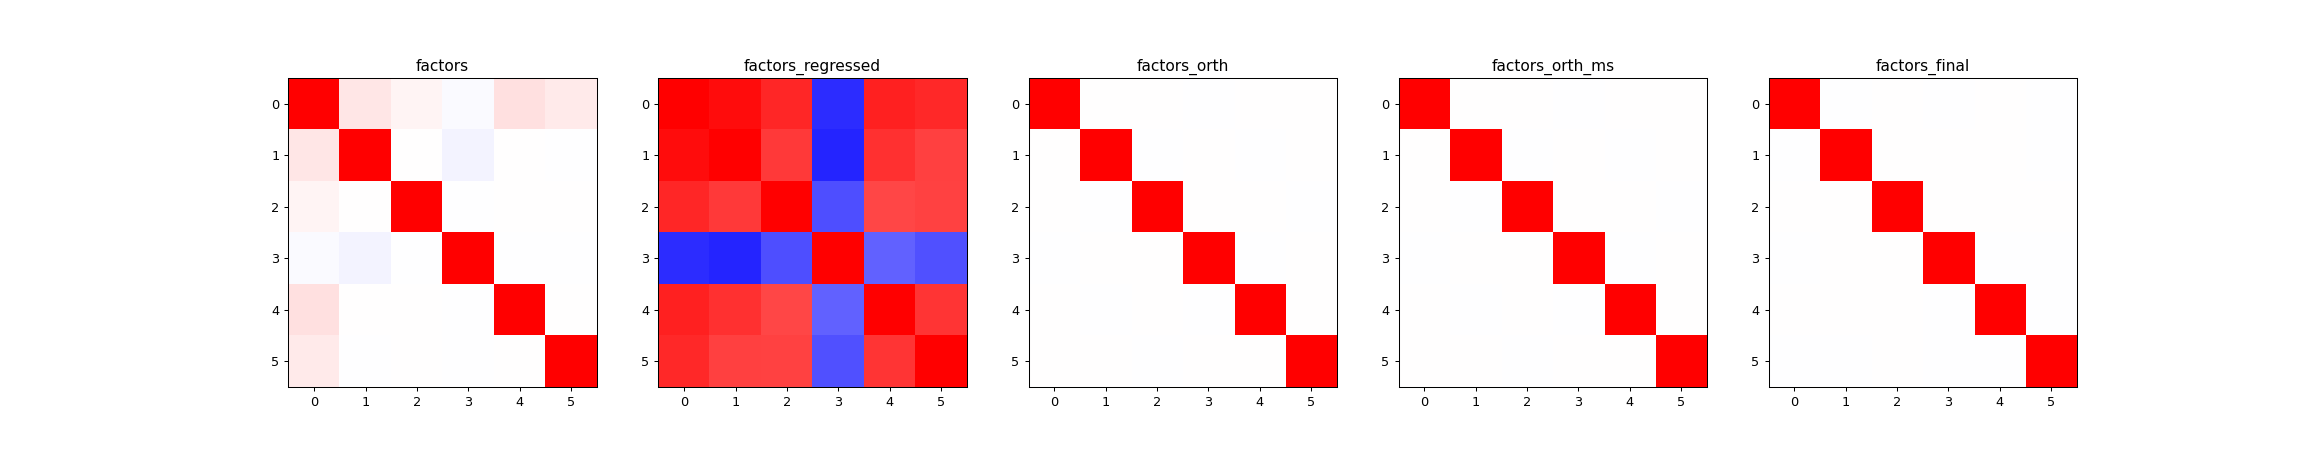

In [169]:
fig, axs = plt.subplots(1, 5, figsize=(25,5))
axs[0].imshow(np.corrcoef(factors_original), cmap='bwr', clim=[-1,1])
axs[0].set_title('factors')
axs[1].imshow(np.corrcoef(factors_regressed), cmap='bwr', clim=[-1,1])
axs[1].set_title('factors_regressed')
axs[2].imshow(np.corrcoef(factors_orth), cmap='bwr', clim=[-1,1])
axs[2].set_title('factors_orth')
axs[3].imshow(np.corrcoef(factors_orth_ms), cmap='bwr', clim=[-1,1])
axs[3].set_title('factors_orth_ms')
axs[4].imshow(np.corrcoef(factors_final[:-1]), cmap='bwr', clim=[-1,1])
axs[4].set_title('factors_final');

<IPython.core.display.Javascript object>


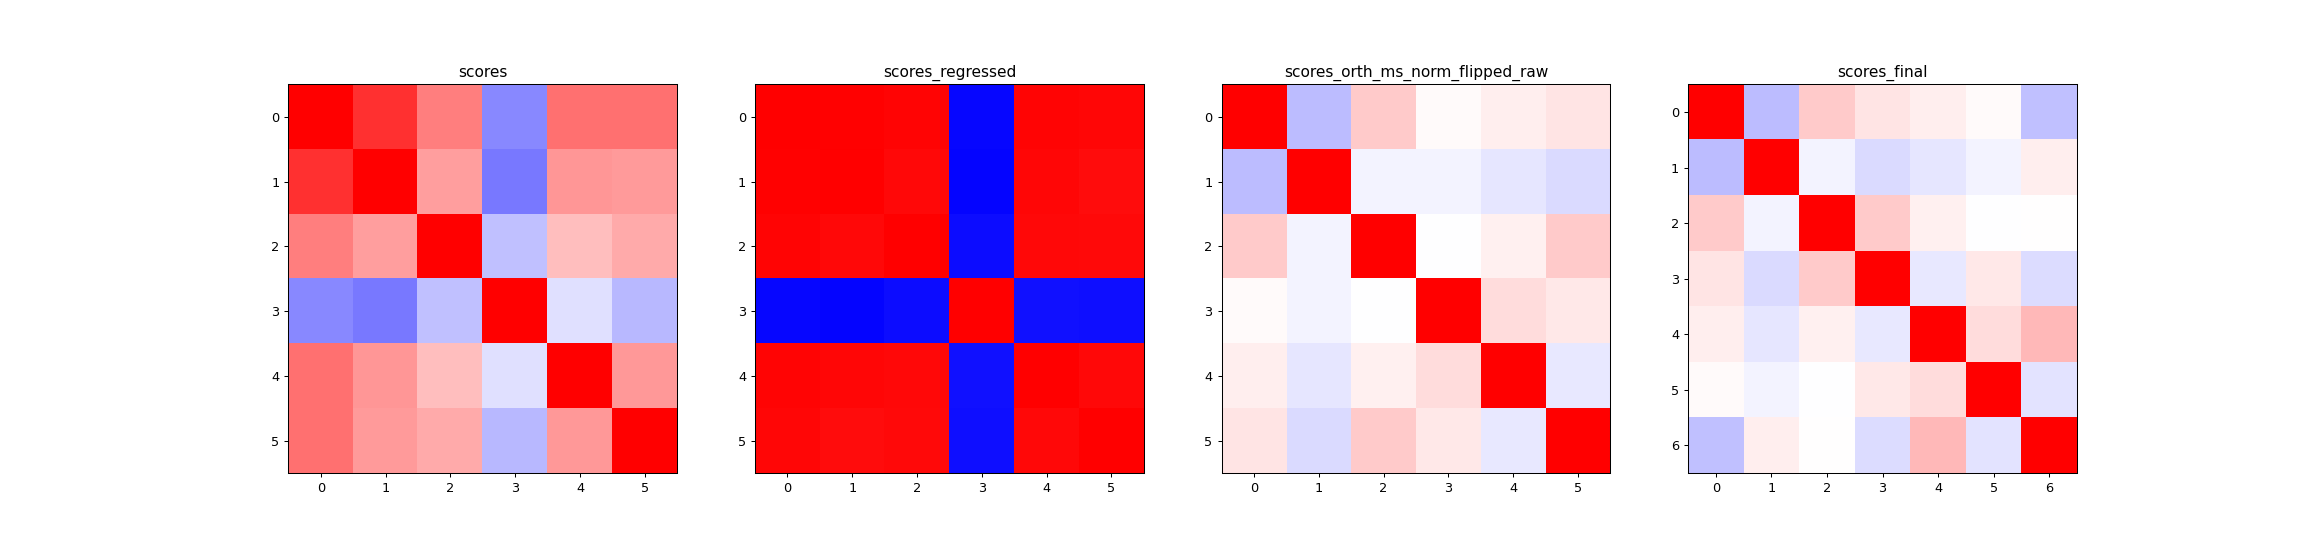

Text(0.5, 1.0, 'scores_final')

In [170]:
fig, axs = plt.subplots(1, 4, figsize=(25,6))
axs[0].imshow(np.corrcoef(scores_original), cmap='bwr', clim=[-1,1])
axs[0].set_title('scores')
axs[1].imshow(np.corrcoef(scores_regressed), cmap='bwr', clim=[-1,1])
axs[1].set_title('scores_regressed')
axs[2].imshow(np.corrcoef(scores_orth_ms_norm_flipped_raw), cmap='bwr', clim=[-1,1])
axs[2].set_title('scores_orth_ms_norm_flipped_raw')
axs[3].imshow(np.corrcoef(scores_final), cmap='bwr', clim=[-1,1])
axs[3].set_title('scores_final')


In [171]:
fig, axs = plt.subplots(4, 1, figsize=(24,24), sharex=True)
axs[0].plot(np.arange(scores_original.shape[1])/Fs,  scores_original.T + 10*scores_original.std(1).mean()*np.arange(params['rank'])[None,:]);
axs[0].set_title('scores')
axs[1].plot(np.arange(scores_original.shape[1])/Fs,  scores_regressed.T + 10*scores_regressed.std(1).mean()*np.arange(params['rank'])[None,:]);
axs[1].set_title('scores_regressed')
axs[2].plot(np.arange(scores_original.shape[1])/Fs,  scores_orth.T + 10*scores_orth.std(1).mean()*np.arange(params['rank'])[None,:]);
axs[2].set_title('scores_orth_ms')
axs[3].plot(np.arange(scores_original.shape[1])/Fs,  scores_final.T + 10*scores_final.std(1).mean()*(np.arange(params['rank']+1))[None,:]);
axs[3].set_title('scores_final')


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'scores_final')

In [172]:
weights = factors_final.copy()
sf_weights = (sf[iscell].T * weights.T).T.reshape(weights.shape[0], data_rois.FOV_height, data_rois.FOV_width)

%matplotlib notebook

fig, ax = plt.subplots(figsize=(16,8))
roicat.visualization.display_toggle_image_stack(
    sf_weights, 
    clim=[-1*sf_weights.max()/4, sf_weights.max()/4],
    fig=fig,
    ax=ax,
    cmap='bwr',
)

# %matplotlib inline

<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, description='i_frame', max=6), Output()), _dom_classes=('widget-inter…

In [173]:
def make_evr_power_curve(factors, data, powers=[0, 1, 2, 3, 5, 10], device='cpu'):
    decoder = bmi_idap.decoder.Decoder_angle_magnitude(
        F=factors.T,
        device=device
    )
    
    Ds = [decoder(X=data, power=p)[0] for p in powers]
    
    evrs = [similarity.orthogonalize(data.T, d.T, device=device, method='OLS')[2] for d in tqdm(Ds)]
    
    return evrs

In [174]:
components_pca, scores_pca, singVals_pca, EVR_pca = decomposition.torch_pca(neural_data_toUse.T, mean_sub=True, device=device, return_numpy=True)

In [175]:
vals_power = np.concatenate([[0], math_functions.bounded_logspace(0.1, 100, 30)])

# evrs = [make_evr_power_curve(f, neural_data_toUse, powers=vals_power, device=device) for f in [components_pca.T[:params['rank']], factors_orth_ms_ordered_norm]]
evrs = [make_evr_power_curve(f, dFoF, powers=vals_power, device=device) for f in [components_pca.T[:params['rank']], factors_final[:-1]]]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


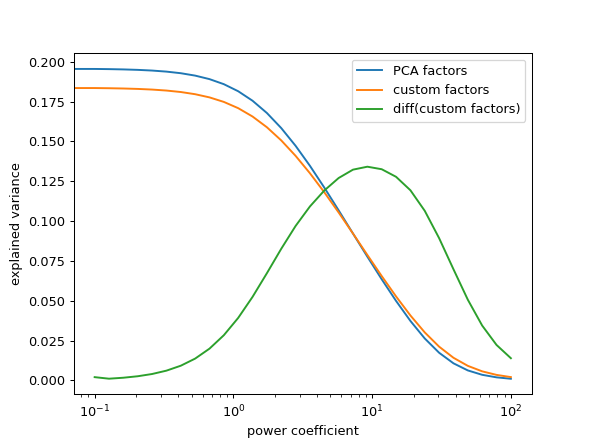

In [176]:
plt.figure()
plt.plot(vals_power, evrs[0])
plt.plot(vals_power, evrs[1])
plt.plot(vals_power[1:], np.diff(evrs[1])*-10)

plt.ylabel('explained variance')
plt.xlabel('power coefficient')
plt.xscale('log')
plt.legend(['PCA factors', 'custom factors', 'diff(custom factors)'])
# plt.ylim([0, 0.5])

In [177]:
results['manifold_alignment'] = {}

results['manifold_alignment']['components_pca'] = components_pca
results['manifold_alignment']['vals_power'] = vals_power
results['manifold_alignment']['evrs_pca'] = evrs[0]
results['manifold_alignment']['evrs_factors'] = evrs[1]

In [198]:
params['simulation'] = {}

params['simulation']['power'] = 1.5
params['simulation']['idx_factor'] = 0
params['simulation']['idx_avg'] = -1
params['simulation']['thresh_reward'] = 2.8
params['simulation']['thresh_quiescence_cursor'] = 0.2 * params['simulation']['thresh_reward']
params['simulation']['duration_quiescence_hold'] = 3
params['simulation']['duration_threshold_hold'] = 3
params['simulation']['win_smooth_cursor'] = 3

In [199]:
decoder = bmi_idap.decoder.Decoder_angle_magnitude(
    F=results['factors']['factors_final'].T,
    device=device,
    power=params['simulation']['power'],
)

D, CS, M = decoder(dFoF)

In [200]:
params['simulation']['ptile_quiescence_avgVec'] = 0.8
params['simulation']['thresh_quiescence_avgVec'] = torch.quantile(CS[-1], q=params['simulation']['ptile_quiescence_avgVec'])

In [201]:
num_rewards, sm = bmi_idap.decoder.simple_cursor_simulation(
    D.T, 
    CS.T, 
    idx_cursor=params['simulation']['idx_factor'], 
    idx_avg=params['simulation']['idx_avg'], 
    thresh_reward=params['simulation']['thresh_reward'], 
    thresh_quiescence_avgVec=params['simulation']['thresh_quiescence_avgVec'], 
    thresh_quiescence_cursor=params['simulation']['thresh_quiescence_cursor'], 
    duration_quiescence_hold=params['simulation']['duration_quiescence_hold'],
    duration_threshold_hold=params['simulation']['duration_threshold_hold'],
    win_smooth_cursor=params['simulation']['win_smooth_cursor'],
)

100%|████████████████████████████████| 108000/108000 [00:09<00:00, 11478.76it/s]


In [202]:
rewards_per_min = num_rewards / (D.shape[1] / (Fs*60*1))

print(f"Rewards per minute: {rewards_per_min :.3f}")

Rewards per minute: 0.767


In [203]:
plt.figure(figsize=(20,5))
plt.plot(sm['cursor'])
plt.plot(sm['timeSeries_avgVec'], alpha=0.3)
plt.plot(sm['rewards']*0.5, linewidth=5)
plt.plot(sm['CS_quiescence']*0.3, alpha=0.3)
plt.plot(sm['CE_trial']*0.2)
plt.title('simulated experiment')
plt.xlabel('time (frames)');

<IPython.core.display.Javascript object>

In [204]:
results['simulation'] = {}

results['simulation']['idx_factor'] = params['simulation']['idx_factor']
results['simulation']['D'] = D
results['simulation']['CS'] = CS
results['simulation']['M'] = M
results['simulation']['num_rewards'] = num_rewards
results['simulation']['rewards_per_min'] = rewards_per_min
results['simulation']['sm'] = sm

In [205]:
plt.figure(figsize=(20,5))
plt.plot(CS.T.cpu());
plt.xlabel('time (frames)')
plt.ylabel('Cosine Similarity of factors + avgVec');

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


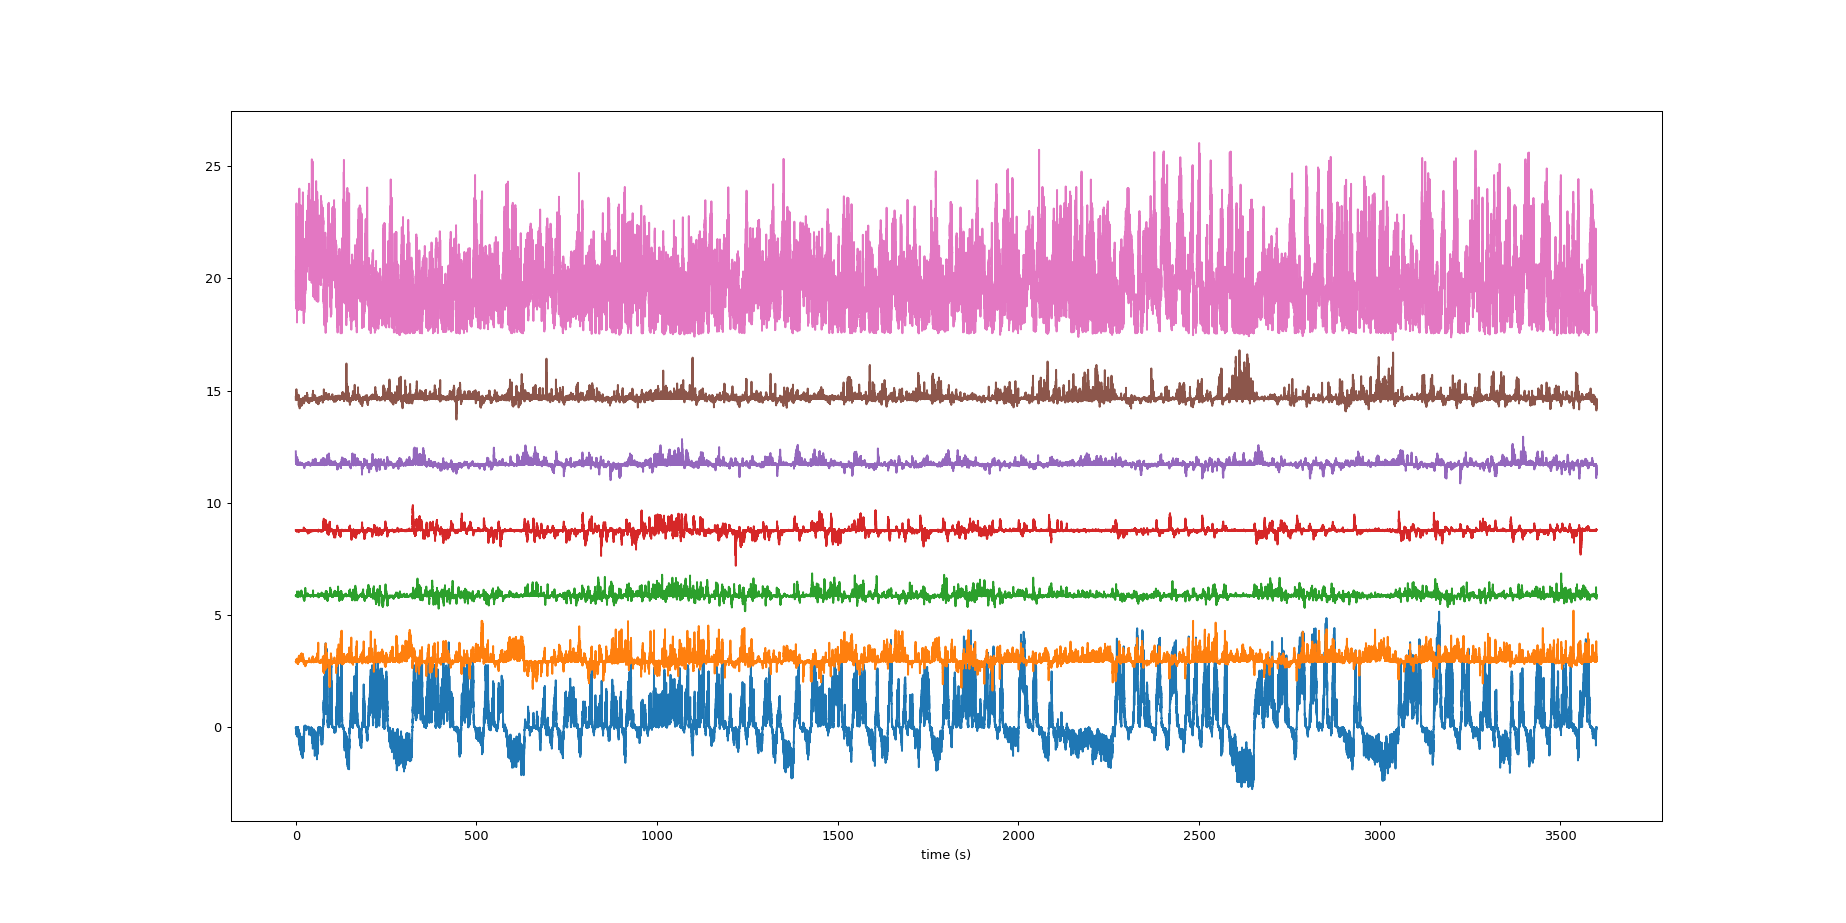

In [206]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(D.shape[1])/Fs, (D.cpu() + torch.arange(D.shape[0])[:,None]*D.std(1).mean().cpu()*7).T)
plt.xlabel('time (s)');

<IPython.core.display.Javascript object>


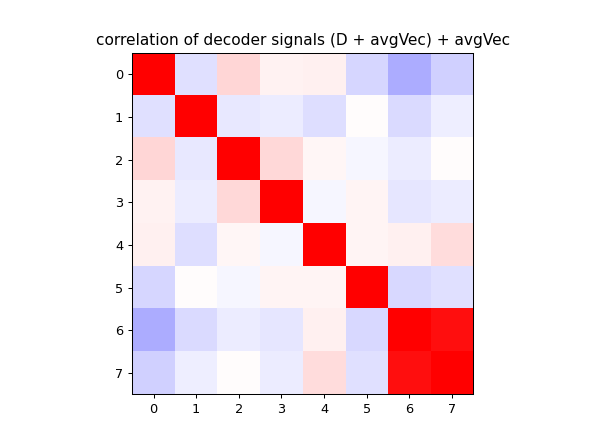

In [207]:
plt.figure()
plt.imshow(
    np.corrcoef(np.concatenate(
        (D.cpu(), dFoF_mean[None,:]), axis=0   
    )), vmin=-1, vmax=1, cmap='bwr'
);
plt.title('correlation of decoder signals (D + avgVec) + avgVec');

In [111]:
directions = np.arange(params['rank']) * (360 / params['rank'])

In [144]:
x, y = np.cos(np.deg2rad(directions)), np.sin(np.deg2rad(directions))
xy = np.stack((x,y), axis=1)
np.random.shuffle(xy)

In [145]:
test1 = M[:-1].T.cpu().numpy() @ xy
test2 = D[:-1].T.cpu().numpy() @ xy

In [146]:
test3 = np.einsum('ij,ik -> ikj', M[:-1].cpu().numpy(), xy)

<IPython.core.display.Javascript object>


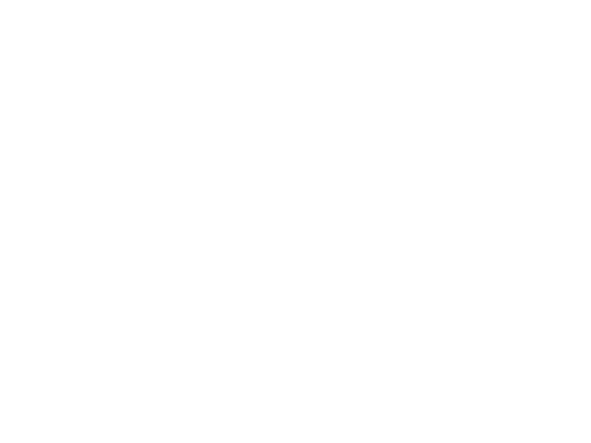

In [147]:
plt.figure()
plt.plot(test3[:,0,0], test3[:,1,0])

<IPython.core.display.Javascript object>


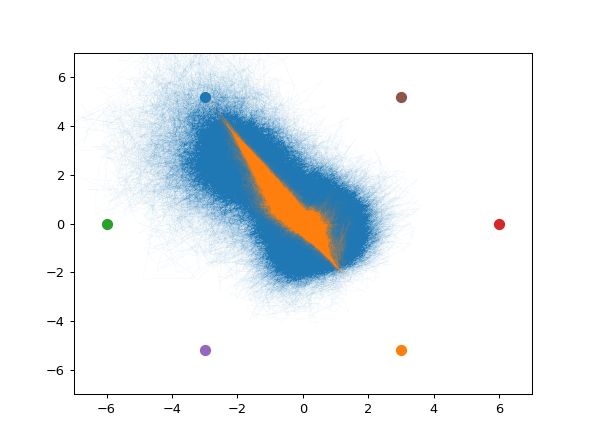

(-7.0, 7.0)

In [148]:
%matplotlib notebook

plt.figure()
[plt.scatter(xy[ii,0]*6, xy[ii,1]*6, s=60) for ii in range(len(x))]
plt.plot(test1[:,0], test1[:,1], linewidth=0.02)
plt.plot(test2[:,0], test2[:,1], linewidth=0.02)
plt.xlim([-7, 7])
plt.ylim([-7, 7])

visualization of final traces and masks

# Save it all

In [209]:
weights_day0 = {
    "factors" : results['factors']['factors_final'],
    "iscell_custom": results['data']['iscell'],
    "spatialFootprints": results['data']['spatialFootprints'],
}

scipy.io.savemat(str(Path(params['paths']['path_save_weights']).with_suffix('.mat')) , weights_day0)
np.save(str(Path(params['paths']['path_save_weights']).with_suffix('.npy')) , weights_day0)


file_helpers.pickle_save(
    obj={'results': results, 'params': params},
    path_save=str(Path(params['paths']['path_save_results']).with_suffix('.pkl')),
)